## pre_trained GPT모델 Fine-tuning 시키기
- Fire-tuning에 필요한 데이터셋은 ChatCOmpletions API와 동일한 형식의 대화 형태여야 하며, 각 메시지에 role별로 content가 들어간 메시지 목록이어야 함(system, user, assistant가 존재해야 함)
- OpenAI의 Fine-tuning API활용시 최소 10개 이상의 대화 데이터가 필요하며, 비용상 처음부터 많은 양으로 진행하기보다는 50개 미만의 소량의 데이터셋으로 학습시켜 결과를 확인하고 필요시 추가하는 것이 좋음
- OpenAI 공식 페이지에서는 100개 미만의 데이터를 소량의 데이터로 정의하고 있음
- Fine-tunung전에 모델에 가장 잘 맞는 지침 및 프롬포트를 설계한 뒤 해당 텍스트가 포함된 학습 데이터를 제작하는 것이 좋음
- 적어도 일부 학습 데이터에는 기존 모델이 '원하는 대로 작동되지 않았을 경우'에 제대로 된 응답이 들어간 데이터가 Fine-tuning에 포함되어야 성능을 크게 향상시킬 수 있음
  - **원하는대로 작동하지 않았던 응답 예시** - Q: 프랑스의 수도는 어디야? A: 프랑스는 세계에서 가장 유명한 관광도시에요.
  - **Fine-tuning에 넣어줄 제대로 된 데이터 예시** - Q:프랑스의 수도는 어디야? A:프랑스의 수도는 파리 입니다.

In [1]:
!pip install tiktoken

In [1]:
from openai import OpenAI
from getpass import getpass
from datetime import datetime
from collections import defaultdict   # 딕셔너리에 존재하지 않는 key에 대한 접근 시, 에러 대신 디폴트값을 생성해주는 클래스
import numpy as np
import time 
import json
import tiktoken   # OpenAI모델들이 사용하는 base 토큰화 및 인코딩 지원 클래스

In [2]:
MY_API_KEY = getpass.getpass("OpenAI API Key :")

OpenAI API Key : ········


In [3]:
client = OpenAI(api_key=MY_API_KEY)

### 1. Fine-tuning 전 데이터 로드 및 데이터 검증
- Fine-tuning은 시간과 비용이 많이 들 수 있기 때문에 사전에 적합한 데이터 형태인지를 검증하고 진행하는 것이 안정적임
- OpenAI의 Fine-tuning API 사용시, 데이터의 구조는 JSONL로 구성되어야 함
- **JSONL(JSON Lines)** : 일반 JSON이 전체 데이터를 하나의 객체로 보는 것에 비해, JSONL은 한 줄당 JSON객체가 존재하는 형태로 한 줄씩 또는 청크 단위로 읽고 쓰는 것에 효율적이며 대규모의 데이터셋을 구성하는데 적합함

#### 1) 데이터를 직접 JSONL 파일로 저장하기

In [4]:
data = [
    {"messages" : [
        {"role":"system", "content":"You are a chatbot that gives clear answers."},
        {"role":"user", "content":"What can i do here?"},
        {"role":"assistant", "content":"Ask a question about the part you want."}
    ]},
    {"messages": [
        {"role":"system", "content":"You are a chatbot that gives clear answers."},
        {"role":"user", "content":"I feel sick."},
        {"role":"assistant", "content":"Please describe your symptoms in detail."}
    ]}
]

with open("data/my_dataset.jsonl", "w", encoding='utf-8') as f :
    # JSOM 파일 저장 시 한 줄에 JSON객체(딕셔너리)를 하나씩 저장해주는 방식
    for i in data :
        f.write(json.dumps(i) + '\n')

#### 2) OpenAI 샘플용 JSONL 데이터 활용

In [5]:
data_path = "data/toy_chat_fine_tuning.jsonl"

with open(data_path, 'r', encoding='utf-8') as f :
    # JSONL은 불러올 때도 내부의 JSON객체들을 하나씩 불러와서 저장해야 함
    dataset = [json.loads(line) for line in f]

print("샘플 수 :", len(dataset))
dataset

# 하나의 messages에 role이 여러개 있는 것은 multi-turn 대화(질의 응답이 여러번 이루어진 형태)

샘플 수 : 5


[{'messages': [{'role': 'system',
    'content': 'You are a happy assistant that puts a positive spin on everything.'},
   {'role': 'user', 'content': 'I fell off my bike today.'},
   {'role': 'assistant',
    'content': "It's great that you're getting exercise outdoors!"}]},
 {'messages': [{'role': 'system',
    'content': 'You are a happy assistant that puts a positive spin on everything.'},
   {'role': 'user', 'content': 'I lost my tennis match today.'},
   {'role': 'assistant', 'content': "It's ok, it happens to everyone."},
   {'role': 'user', 'content': 'But I trained so hard!'},
   {'role': 'assistant', 'content': 'It will pay off next time.'},
   {'role': 'user', 'content': "I'm going to switch to golf."},
   {'role': 'assistant', 'content': 'Golf is fun too!'},
   {'role': 'user', 'content': "I don't even know how to play golf."},
   {'role': 'assistant', 'content': "It's easy to learn!"}]},
 {'messages': [{'role': 'user', 'content': 'I lost my book today.'},
   {'role': 'assi

In [39]:
dataset[0]

{'messages': [{'role': 'system',
   'content': 'You are a happy assistant that puts a positive spin on everything.'},
  {'role': 'user', 'content': 'I fell off my bike today.'},
  {'role': 'assistant',
   'content': "It's great that you're getting exercise outdoors!"}]}

In [6]:
dataset[0]['messages']

[{'role': 'system',
  'content': 'You are a happy assistant that puts a positive spin on everything.'},
 {'role': 'user', 'content': 'I fell off my bike today.'},
 {'role': 'assistant',
  'content': "It's great that you're getting exercise outdoors!"}]

### 실제 Fine-tuning에 사용할 시사 상식 대화 데이터 로드(10개)

In [7]:
data_path = "data/common_sense_train.jsonl"

with open(data_path, 'r', encoding='utf-8') as f :
    dataset = [json.loads(line) for line in f]

print("샘플 수 :", len(dataset))
dataset

샘플 수 : 10


[{'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': "제주도는 '삼다도'라고 불리기도 하는데 '삼다'에 해당되는 것은 무엇일까요?"},
   {'role': 'assistant',
    'content': "정답은 '여자', '바람', '돌' 이고 이 세가지가 많다고 해서 '삼다' 라고 불림."}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user',
    'content': '뮤지컬, 연극, 오페라, 음악회 등의 공연이 끝난 후에 관객이 박수를 보내 배우들을 다시 무대로 나오게 하는 것을 무엇이라 할까요?'},
   {'role': 'assistant',
    'content': "정답은 '커튼콜'이며 '앵콜'과는 달리 추가 무대를 요청하는 것이 아니라 단순히 등장을 요구하는 것."}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '프랑스의 수도는 어디인가요?'},
   {'role': 'assistant',
    'content': '프랑스의 수도는 파리임. 파리는 예술의 도시라고 불리며 세계 최고의 관광 도시 중 하나임.'}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '세계에서 가장 큰 바다는 무엇인가요?'},
   {'role': 'assistant',
    'content': '세계에서 가장 큰 바다는 태평양임. 태평양은 오대양의 하나로 지구 표면의 1/3을 차지하며 표면적

#### 데이터 검증 진행
- openAI 검증 코드 : https://cookbook.openai.com/examples/chat_finetuning_data_prep

##### 1. 데이터셋이 Fine-tuning API에서 기대하는 형식을 준수하는지 검증

In [14]:
# defaultdict 예시
format_errors = defaultdict(int)

In [15]:
format_errors

defaultdict(int, {})

In [16]:
format_errors['test']
format_errors

defaultdict(int, {'test': 0})

In [17]:
format_errors['test'] += 1
format_errors

defaultdict(int, {'test': 1})

In [18]:
# defaultdict : 딕셔너리를 만들면서 존재하지 않는 key에 대한 디폴트값을 생성하는 클래스
#                            (int로 설정할 경우 정수형의 기본값인 0이 들어가서 동작함)
format_errors = defaultdict(int)

# dataset은 list형태이며, ex는 하나의 messages로 dict 형태임
for ex in dataset :
    # <ex가 dict타입이 아니라면 카운트>
     # isinstance : 어떤 클래스의 객체인지 확인하는 함수(객체명, 클래스명)으로 작성하며 True, False로 반환
    if not isinstance(ex, dict) :            # ex가 dict 형태가 아니라면
        format_errors["data_type"] += 1      # "data_type"의 value를  1증가
        continue

    # <messages의 value 값이 list가 아니라면 카운트>
     # ex에서 "messages"라는 key가 있으면 해당 value값을 출력(없으면 None 반환)
    message = ex.get("messages", None)
    if not messages :        # messages가 None이라면 False로 인지되고 조건식 전체는 True가 됨
        format_errors["missing_messages_list"] += 1
        continue

    # messages(리스트) 내부의 각 딕셔너리에 접근
    for messaage in messages :
        # <key값에 "role"과 "content"가 포함되어 있지 않다면 카운트>
        if "role" not in message or "content" not in message :
            format_errors["message_missing_key"] += 1

        # <모든 message의 key값에서 아래 5개 외에 다른 값이 있다면 카운트>
         # any : 괄호안의 조건 중 하나라도 True인 경우 True를 반환
         # (채팅 API외에 모든 API들이 가질 수 있는 key의 종류는 아래 5가지)
        if any(key not in ("role","content","name","function_call", "weight") for key in message) :
            format_errors["message_unrecognized_key"] += 1
        # <message의 "role"이 아래 4개 중 하나가 아니거나 값이 없다면(None) 카운트>
         # (message의 "role"의 value값이 될 수 있는 것은 아래 4가지)
        if messaage.get("role", None) not in ("system", "user", "assistant", "function") :
            format_errors["unrecognized_role"] += 1

        # <message의 "content"에 value값이 존재하지 않거나 "content"가 문자열이 아니라면 카운트>
         # ("content"에는 질의나 응답이 들어가야하므로 문자열 형태여야 함)
        content = messaage.get("content", None)
        if not content or not isinstance(content, str) :
            format_errors["missing_content"] += 1

    # <각 message의 "role"에서 "assistant"의 응답이 하나라도 없다면 카운트>
     # message들 중 "assistant"의 응답이 없으면 False가 되고 앞에 not이 붙어서 True가 되면 조건문 실행
    if not any(message.get("role", None)=="assistant" for message in messages) :
        format_errors["example_missing_assistant_message"] += 1

# 발생한 에러가 있다면(format_errors에 값이 있다면) 모둔 유형의 에러에 대한 내용 및 개수 출력
if format_errors :
    print("에러 발견 :")
    for key, value in format_errors.items() :
        print(f"{key}: {value}")
else :
    print("에러가 없습니다!")

NameError: name 'messages' is not defined

In [19]:
# defaultdict: 딕셔너리를 만들면서 존재하지 않는 key에 대한 디폴트값을 생성하는 클래스 (int로 설정할 경우, 정수형의 기본값인 0이 들어가서 동작함)
format_errors = defaultdict(int)

# dataset은 list형태이며, ex는 하나의 messages로 dict 형태임 
for ex in dataset:
    # <ex가 dict타입이 아니라면 카운트>
    # isinstance: 어떤 클래스의 객체인지 확인하는 함수(객체명, 클래스명)으로 작성하며 True, False로 반환 
    if not isinstance(ex, dict): # ex가 dict의 형태가 아니라면
        format_errors["data_type"] += 1 # "data_type"의 value를 1 증가
        continue

    # <messages의 value값이 list가 아니라면 카운트>
    # ex에서 "messages"라는 key가 있으면 해당 value값을 출력(없으면 None 반환)
    messages = ex.get("messages", None)
    if not messages: # messages가 None이라면, False로 인지되고 조건식 전체는 True가 됨 
        format_errors["missing_messages_list"] += 1
        continue
    
    # <messages(리스트) 내부의 각 딕셔너리에 접근>
    for message in messages:
        # <key값에 "role"가 "content"가 포함되어 있지 않는다면 카운트>
        if "role" not in message or "content" not in message:
            format_errors["missing_messages_key"] += 1

        # <모든 message의 key값에서 아래 5개 외에 다른 값이 이싸면 카운트>
        # any: 괄호안의 조건 중 하나라도 True인 경우 True를 반환
        # (채팅 API 외에 모든 API들이 가질 수 있는 key의 종류는 아래 5가지)
        if any(key not in ("role", "content", "name", "function_call", "weight") for key in message):
            format_errors["message_unrecognized_key"] += 1

        # <message의 "role"이 아래 4개 중 하나가 아니거나 값이 없다면(None) 카운트>
        # message의 "role"의 value값이 될 수 있는 것은 아래 4가지 
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1

        # <message의 "content"에 value값이 존재하지 않거나 "content"가 문자열이 아니라면 카운트>
        # ("content"에는 질의나 응답이 들어가야하므로 문자열 형태여야 함)
        content = message.get("content", None)
        if not content or not isinstance(content, str):
            format_errors["missing_content"] += 1

    # <각 message의 "role"에서 "assistant"의 응답이 하나라도 없다면 카운트>
    # message들 중 "assistant"의 응답이 없으면 False가 되고 앞에 not이 붙어서 True가 되면 조건문 실행 
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

# 발생한 에러가 있다면(format_errors에 값이 있다면) 모든 유형의 에러에 대한 내용 및 개수 출력 
if format_errors:
    print("에러 발견:")
    for key, value in format_errors.items():
        print(f"{key}: {value}")

else:
    print("에러가 없습니다.")

에러가 없습니다.


#### 2. 누락된 메시지 식별 및 메시지와 토큰 수 확인

- 필요한 함수 정의

In [20]:
encoding = tiktoken.get_encoding("o200k_base")
print(encoding.encode("hello my name is seoan"))

[24912, 922, 1308, 382, 21836, 270]


In [21]:
# tiktoken : OoenAI 모델들이 사용하는 토큰화 및 인코딩 지원 모듈
 # get_encoding : 토큰화 및 인코딩 모델 검색
 #"o200k_base" : gpt-4o 및 gpt-4o-mini 가 사용하는 모델명(그 외 모델들은 "cl100k_base"모델명을 사용)
encoding = tiktoken.get_encoding("o200k_base")

# <메시지 목록의 총 토큰 수 계산 함수>
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1) :
    num_tokens = 0
    for messaage in messages :
        # message가 있다면 'role', 'content', 이름 감싸는 '{}'가 있을 것이므로 각 1개씩 해서 총 3개 추가
        num_tokens += tokens_per_message

        for key, value in messaage.items() :
            
            # encode : tiktoken의 모델로 토큰화 및 인코딩 실행
            # value값('role' 및 'content'의 value)이 토큰화+인코딩 된 길이가 num_tokens에 더해짐
            num_tokens += len(encoding.encode(value))
            # 만약 key에 name이 있다면 (사용자가 assistant의 이름을 지정한 경우 name값이 생성됨)
            if key == "name" :
                num_tokens + tokens_per_name

    # num_tokens을 3씩 증가시키는 이유
     # 1) 하나의 message 전체를 감싸는 토큰 '{}'
     # 2) 하나의 message의 끝을 표시하는 특수 토큰 '<SEP>' 등
     # 3) 각각의 message를 구분해주는 구분 토큰 : ',' 등
    num_tokens += 3
    return num_tokens

# assistant가 응답한 메시지의 총 토큰 수(모델의 최대 출력 토큰(max_output_tokens)기준에 맞는지 판단하기 위함)
def num_assistant_tokens_from_messages(messages) :
    num_tokens = 0 
    for message in messages :
        if message['role'] == 'assistant' :
            # content의 value값만 토큰화 + 인코딩 하여 개수에 추가
            num_tokens += len(encoding.encode(message['content']))
    return num_tokens

# message의 토큰 길이에 대한 통계 정보 출력
def print_statistics(values) :
    print(f"min/max: {min(values)}, {max(values)}")
    print(f"mean/median: {np.mean(values)}, {np.median(values)}")

- 코드 및 함수 실행

In [22]:
max_output_tokens = 16384        # 모델 최대 출력 토큰 수(gpt-4o-mini의 경우, 16,384개)
n_missing_system = 0             # role에 'system'이 없는 경우의 대화를 카운트
n_missing_user = 0               # role에 'user'가 없는 경우의 대화를 카운트
n_messages = []                  # 각 대화의 message 개수가 담길 빈 리스트
total_tokens_lens = []           # 각 대화의 총 코튼 수 가 담길 빈 리스트
assistant_message_lens = []      # assistant가 보낸 메시지이 - 길이가 단길 빈 리스트

for ex in dataset :
    messages = ex['messages']
    # 각 message에서 role이 system인 경우가 하나도 없다면
    if not any(message['role']=='system' for message in messages) :
        n_missing_system += 1
    # 각 message에서 role이 user인 경우가 하나도 없다면
    if not any(message['role']=='user' for message in messages) :
        n_missing_user += 1

    # 각 messages의 message개수를 리스트에 추가
    n_messages.append(len(messages))
    # message목록의 총 토큰 수 함수 실행 후 리스트에 추가
    total_tokens_lens.append(num_tokens_from_messages(messages))
    # 모델 출력 토큰 함수 실행 후 리스트에 추가
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))

print("system 메시지 누락 수 :", n_missing_system)
print("user 메시지 누락 수 :", n_missing_user)

print()
print("### 대화 당 메시지 수 통계 :")
print_statistics(n_messages)

print()
print("### 대화 당 전체 토큰 수 통계 :")
print_statistics(total_tokens_lens)

print()
print("### 대화 당 모델 응답 토큰 수 통계 :")
print_statistics(assistant_message_lens)

print()
# total_tokens_lens(각 메시지들의 총 코큰수들을 담은 리스트)에서 각각의 값을 16384개와 비교하여 더 많으면 카운트
 # True는 파이썬에서 1이므로 이를 sum한다면 True값의 개수를 파악할 수 있음
n_too_long = sum(i > max_output_tokens for i in total_tokens_lens)
print(f"\n{n_too_long}개의 대화가 {max_output_tokens}개 토큰 제한을 초과하며, 초과된 부분은 Fine-tuning시 잘릴 수 있습니다.")

system 메시지 누락 수 : 0
user 메시지 누락 수 : 0

### 대화 당 메시지 수 통계 :
min/max: 3, 3
mean/median: 3.0, 3.0

### 대화 당 전체 토큰 수 통계 :
min/max: 69, 110
mean/median: 85.9, 85.5

### 대화 당 모델 응답 토큰 수 통계 :
min/max: 22, 51
mean/median: 34.5, 33.0


0개의 대화가 16384개 토큰 제한을 초과하며, 초과된 부분은 Fine-tuning시 잘릴 수 있습니다.


#### 3. 적정 epochs 및 비용 추정

In [23]:
MAX_TOKENS_PER_EXAMPLES = 16384    # 모델에 맞는 대화당 최대 토큰 수 설정

# Fine-tuning 시 적정 epochs 지정
# 데이터의 양과 과대적합을 고려하여 OpenAI에서 테스트에 얻어진 적정 기준(공식 홈페이지 제공)
TARGET_EPOCHS = 3            # 기본 base 에포크 수
MIN_DEFAULT_EPOCHS =1        # OpenAI가 제시하는 Fine-tuning에 필요한 최소 epochs 수
MAX_DEFAULT_EPOCHS = 25      # 제시하는 최대 epochs 수 (이 횟수를 초과하면 과대적합에 빠질 가능성이 높다고 판단)
MIN_TARGET_EXAMPLES = 100    # OpenAI가 제시하는 Fine-tuning에 필요한 최소 데이터 수
MAX_TARGET_EXAMPLES =25000   # 제시하는 최대 데이터 수(비용 및 시간 효율을 위해 상한 설정)

# 즉, 데이터의 양과 원하는 epochs 수에 따라 최저기준과 최대기준을 비교하여 적정 epoch를 구하고 적용하는 방식

n_epochs = TARGET_EPOCHS    # 입력되는 타켓 에포크에 따라 실제로 적용될 에포크(n_epochs) 설정
n_train_examples = len(dataset)  # 대화의 개수(messages의 개수 = 데이터의 개수)

# 해당 조건식은 OpenAI가 제시하는 수식으로 사전에 대략적인 파악을 위한 것이지 무조건적인 절대 기준은 아님(실제 사용자 테스트가 더 중요)
if (n_train_examples * TARGET_EPOCHS) < MIN_TARGET_EXAMPLES :    # 우리 데이터의 개수와 타켓 에포크 수를 곱한 값이 최저 샘플수보다 작다면
    # ephocs최대치(25회)와 최소 데이터 100개에서 우리 데이터 수를 나눈 몫을 비교하여 더 낮은 값으로 에포크 설정
    n_epochs = min(MAX_DEFAULT_EPOCHS, (MIN_TARGET_EXAMPLES // n_train_examples))

elif (n_train_examples * TARGET_EPOCHS) < MAX_TARGET_EXAMPLES :
     n_epochs = max(MIN_DEFAULT_EPOCHS, (MAX_TARGET_EXAMPLES // n_train_examples))

# 각 대화별 총 토큰수가 담긴 리스트에서 각각 16384와 비교하여 낮은 값으로 합해서 총 토큰수를 계산 (gpt-4o-min모델은 16384개 이상의 토큰이 들어갈 수 없기 때문)
# (실제로 16384개 이상의 토큰을 넣더라도 16384개 까지만 요금이 청구될 것이기 때문에 min함수로 범위 지정)
n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLES, length) for length in total_tokens_lens)

print(f"해당 데이터 셋에는 학습 중 요금이 청구 될 {n_billing_tokens_in_dataset} 개의 토큰이 있습니다.")
print(f"기본적으로 이 데이터 셋에서 {n_epochs} epoch 동안 학습합니다.")
print(f"총 {n_epochs*n_billing_tokens_in_dataset} 개의 토큰에 대해 요금이 청구 됩니다.")

# 토큰의 개수를 통해 토큰 금액 계산기로 계산해보면 대략적인 금액을 Fine_tuning전에 알 수 있음

해당 데이터 셋에는 학습 중 요금이 청구 될 859 개의 토큰이 있습니다.
기본적으로 이 데이터 셋에서 10 epoch 동안 학습합니다.
총 8590 개의 토큰에 대해 요금이 청구 됩니다.


### 2. 실제 학습에 사용될 데이터셋으로 fine-tuning 파일 업로드 객체 생성

In [24]:
# fine-tuning을 위한 파일 생성 객체 만들기
fine_tune_files = client.files.create(
    file = open("data/common_sense_train.jsonl", "rb"),
    purpose = "fine-tune"
)
fine_tune_files

FileObject(id='file-SAB3KDQTc5VS1dXcu3Pb5A', bytes=6176, created_at=1755651707, filename='common_sense_train.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

### 3. Fine-tuning 진행 및 결과 확인
- 1회 작업시, gpt-3.5-turbo는 디폴트 epochs가 3이며, 4o 및 4o-mini의 경우 디폴트는 4
- Fine-tuning 작업이 완료된 모델은 OpenAI 시스템에 저장되며, 작업에 할당된 모델 ID를 통해 자유롭게 엑세스 가능
- 작업이 완료되지 않으면 API 사용 요금이 부과되지 않음

#### 작업 객체 생성 및 Fine-tuning시작

In [26]:
fine_tune_job = client.fine_tuning.jobs.create(
    model="gpt-4o-mini-2024-07-18",
    training_file = fine_tune_files.id   # 위에서 발생한 파일 객체의 id(학습에 필요한 데이터 경로와 목적이 들어있음)
)
fine_tune_job

# 작업 상태에 대한 정보가 포함되어 있음

FineTuningJob(id='ftjob-k7zWgH3S9lVDJonMWv5IsJua', created_at=1755652257, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-AHL5BbK86FPDbtJTKtWT5sB2', result_files=[], seed=2043779718, status='validating_files', trained_tokens=None, training_file='file-SAB3KDQTc5VS1dXcu3Pb5A', validation_file=None, estimated_finish=None, integrations=[], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs='auto'))), user_provided_suffix=None, usage_metrics=None, shared_with_openai=False, eval_id=None)

In [27]:
# 작업id 가져오기(홈페이지에서도 확인 가능)
fine_tune_job.id

'ftjob-k7zWgH3S9lVDJonMWv5IsJua'

In [29]:
# 작업 id에 따른 세부사항 확인(작업id, 작업 완료된 모델명, 하이퍼피라미터, 현재 진행상태 등)
client.fine_tuning.jobs.retrieve('ftjob-k7zWgH3S9lVDJonMWv5IsJua')

# status는 running(동작중), validation_files(파일 검증), queued(대기), succeeded(성공), failed(실패), cancelled(취소) 중 하나
# fine_tuned_model은 파일튜닝 완료 후 생성된 개인 모델

FineTuningJob(id='ftjob-k7zWgH3S9lVDJonMWv5IsJua', created_at=1755652257, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=10), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-AHL5BbK86FPDbtJTKtWT5sB2', result_files=[], seed=2043779718, status='validating_files', trained_tokens=None, training_file='file-SAB3KDQTc5VS1dXcu3Pb5A', validation_file=None, estimated_finish=None, integrations=[], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=10))), user_provided_suffix=None, usage_metrics=None, shared_with_openai=False, eval_id=None)

In [32]:
# <실시간 fine-tuning 진행 상황 확인 코드>
while True :
    fine_tune_job_info = client.fine_tuning.jobs.retrieve("ftjob-k7zWgH3S9lVDJonMWv5IsJua")
    print(f"진행 상태 : {fine_tune_job_info.status}")

    if fine_tune_job_info.status == "succeeded" :
        print("Fine-tuning 완료 :")
        break
    elif fine_tune_job_info.status == "failed" :
        print("Fine-tuning 실패 :")
        break

    time.sleep(30)       # 30초 간격으로 체크

진행 상태 : succeeded
Fine-tuning 완료 :


In [34]:
# <fine - tuning에 걸린 시간 확인 코드>
from datetime import datetime, UTC

# fromtimestamp : Unix시간을 UTC(세계표준시간)으로 변환(한국 시간과 9시간 차이)
 # Unix시간 : 유닉스 운영체제에서 사용하는 컴퓨터 시간 표시 방법으로 1970년 1월1일을 기준으로 현재까지 몇 초가 지났는지를 표시
start_time = datetime.fromtimestamp(fine_tune_job_info.created_at, UTC)    # created_at : 작업 시작 시간
finish_time = datetime.fromtimestamp(fine_tune_job_info.finished_at, UTC)  # finished_at : 작업 완료 시간

print("작업 시작 시간 :", start_time)
print("작업 완료 시간 :", start_time)
print("작업에 소요된 시간 :", finish_time - start_time)

작업 시작 시간 : 2025-08-20 01:10:57+00:00
작업 완료 시간 : 2025-08-20 01:10:57+00:00
작업에 소요된 시간 : 0:13:15


In [38]:
# fine-tuning을 진행했던 전체 작업 목록 출력
client.fine_tuning.jobs.list(limit=10) # limit : 출력 개수 제한

# 해당 정보는 openai plateform 홈페이지의 Dashboard 탭에서 좌측 Fine-tuning을 클릭하면 볼 수 있음

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-k7zWgH3S9lVDJonMWv5IsJua', created_at=1755652257, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:seoan::C6RqiuUM', finished_at=1755653052, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=10), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-AHL5BbK86FPDbtJTKtWT5sB2', result_files=['file-W69QpMh7D1Hk5DBzCzYrfF'], seed=2043779718, status='succeeded', trained_tokens=8390, training_file='file-SAB3KDQTc5VS1dXcu3Pb5A', validation_file=None, estimated_finish=None, integrations=[], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=10))), user_provided_suffix=None, usage_metrics=None, shared_with_openai=False, eval_id=None), FineTuningJob(id='ftjob-6nKl7uSqiOILwnxQsiRrClQu', 

In [47]:
# fine-tuning 진행 중인 작업 취소
client.fine_tuning.jobs.cancel("ftjob-k7zWgH3S9lVDJonMWv5IsJua")    # 문자열 내에 작업 id 입력

# 작업 시작후에 잘못 설정된 것을 알게 된 경우 중간에 취소하게되면 불필요한 비용이나 시간낭비를 피할 수 있음(홈페이지에서 Cancel job으로도 취소 가능)

BadRequestError: Error code: 400 - {'error': {'message': 'Job has already completed: ftjob-k7zWgH3S9lVDJonMWv5IsJua', 'type': 'invalid_request_error', 'param': 'fine_tune_id', 'code': 'invalid_cancel'}}

In [44]:
# 완성된 fine-tuning 모델 삭제
client.models.delete("")   # 문자열 내에 완성된 모델명 입력(작업이 완료되면 홈페이지에 게시됨)

# 사용하지 않는 모델들이 많으면 id값을 잘못입력한 경우 이전 버전 모델로 금액이 빠져나갈 수 있기 때문에 정리 차원에서 불필요한 모델들은 삭제할 수 있음

ValueError: Expected a non-empty value for `model` but received ''

### Fine-tuning 완료된 작업 검색(Python 코드를 사용하지 않는 수동 방식)
- !curl : 다양한 프로토콜을 활용하여 데이터를 전송하는데 사용되는 명령 도구로 API직접 상호작용하는데 유용함
-  -H : HTTP요청에 사용자 정의 header를 추가하는데 사용하는 옵션(인증이나 타입을 지정할 때 주로 사용)

In [48]:
# jobs/ 뒤에는 fine-tuning 완료된 작업의 id 입력
!curl https://api.openai.com/v1/fine_tuning/jobs/ftjob-k7zWgH3S9lVDJonMWv5IsJua  \
  -H "Authorization: Bearer $MY_API_KEY"

{
  "object": "fine_tuning.job",
  "id": "ftjob-k7zWgH3S9lVDJonMWv5IsJua",
  "model": "gpt-4o-mini-2024-07-18",
  "created_at": 1755652257,
  "finished_at": 1755653052,
  "fine_tuned_model": "ft:gpt-4o-mini-2024-07-18:seoan::C6RqiuUM",
  "organization_id": "org-AHL5BbK86FPDbtJTKtWT5sB2",
  "result_files": [
    "file-W69QpMh7D1Hk5DBzCzYrfF"
  ],
  "status": "succeeded",
  "validation_file": null,
  "training_file": "file-SAB3KDQTc5VS1dXcu3Pb5A",
  "hyperparameters": {
    "n_epochs": 10,
    "batch_size": 1,
    "learning_rate_multiplier": 1.8
  },
  "trained_tokens": 8390,
  "error": {},
  "user_provided_suffix": null,
  "seed": 2043779718,
  "estimated_finish": null,
  "integrations": [],
  "metadata": null,
  "usage_metrics": null,
  "shared_with_openai": false,
  "eval_id": null,
  "method": {
    "type": "supervised",
    "supervised": {
      "hyperparameters": {
        "n_epochs": 10,
        "batch_size": 1,
        "learning_rate_multiplier": 1.8
      }
    }
  }
}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   990  100   990    0     0   1757      0 --:--:-- --:--:-- --:--:--  1771


- learning_rate_multiplier : 학습률 배수(1은 기본 1r을 그대로 사용, 0.5는 기본 lr의 50%로 사용)
- OpenAI에서 정확한 learning_rate를 공개하고 있지 않고 배수로만 컨트롤 가능함

### 4. Fine-tuning 완료 후 질의응답

In [51]:
completion = client.chat.completions.create(
    model = "ft:gpt-4o-mini-2024-07-18:seoan::C6RqiuUM",    # 파인튜닝 완료 후 생성된 개인 모델명
    messages = [{"role":"user", "content":"우리나라의 첫 대통령은 누구인가요?"}]
)

print(completion.choices[0].message.content)

우리나라의 첫 대통령은 이승만이며 제1공화국 소속 이었습니다. 이승만은 1948년 제1회 대통령 선거를 통해 취임하였으며 이후 1952년과 1956년에도 재선되었습니다.


### Fine-tuning 결과가 좋지 않다고 판단될 경우 대응
**1. 데이터 부분**
1) 데이터 수 추가
   - 가장 효과가 확실 할 수 있음
2) 데이터의 균형과 다양성 고려
   - 너무 일관된 데이터 뿐만 아니라 원하는 응답에 대한 다양한 데이터를 생성
   - 일반적으로 적은 양의 고품질 데이터가 많은 양의 저품질 데이터보다 효과적임
3) 기존 데이터의 문제점 조사
   - 원치 않는 질의-응답 방식의 대화 데이터가 포함되어 있는지 확인(잘못된 패턴이 학습되었을 수 있음)
   - 응답에 필요한 모든 정보가 포함되어 있는지 확인(할루시네이션 발생 가능성 존재)
   - 여러 사람들이 만든 데이터를 합친 경우라면, 일관성 확인(패턴을 찾기 힘든 데이터일 수 있음)

**2. 모델부분**
1) 완료된 모델에 추가로 Fine-tuning 진행
   - 완료된 모델명으로 fine-tuning 추가 작업 가능
2) 하이퍼피라미터 변경
   - epochs, learning_rate 등 변경

### 5. 체크포인트(중간 저장) 모델 활용하기
- Fine-tuning완료 후 체크포인트 모델들을 활용할 수 있음
- 현재는 완료된 작업중 3개 step에 대한 모델만 사용 가능함
- 학습이 완료된 최종 모델의 성능이 애매하거나 수치적으로 과대적합이라고 판단된다면 이전 체크포인트 모델들을 활용할 수 있음

#### 1) 체크포인트 모델 확인

In [53]:
!curl https://api.openai.com/v1/fine_tuning/jobs/ftjob-k7zWgH3S9lVDJonMWv5IsJua/checkpoints \
  -H "Authorization: Bearer $MY_API_KEY"

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.checkpoint",
      "id": "ftckpt_88SMeL5bALcdtK8uPBAn3nTA",
      "created_at": 1755653011,
      "fine_tuned_model_checkpoint": "ft:gpt-4o-mini-2024-07-18:seoan::C6RqiuUM",
      "fine_tuning_job_id": "ftjob-k7zWgH3S9lVDJonMWv5IsJua",
      "metrics": {
        "step": 100,
        "train_loss": 0.0007899602060206234,
        "train_mean_token_accuracy": 1.0,
        "type": "supervised"
      },
      "step_number": 100
    },
    {
      "object": "fine_tuning.job.checkpoint",
      "id": "ftckpt_6q1ePy1XIxl67uJPENJqFR4W",
      "created_at": 1755652999,
      "fine_tuned_model_checkpoint": "ft:gpt-4o-mini-2024-07-18:seoan::C6RqhSGv:ckpt-step-90",
      "fine_tuning_job_id": "ftjob-k7zWgH3S9lVDJonMWv5IsJua",
      "metrics": {
        "step": 90,
        "train_loss": 0.0005208795773796737,
        "train_mean_token_accuracy": 1.0,
        "type": "supervised"
      },
      "step_number": 90
    },
    {
     

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1593  100  1593    0     0   3961      0 --:--:-- --:--:-- --:--:--  3992


#### 2) 체크포인트 모델별 loss, mean_token_accuracy

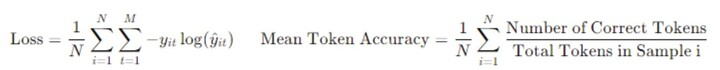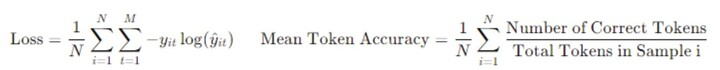

#### **Loss** : 시퀀스(토큰)에 대한 loss로 토큰별 정답일 확률에 대한 오차를 계산
- N : 데이터 개수, M : 데이터 당 토큰 수, y: 실제 정답 토큰 확률(원핫인코딩 상태로 0or1), y(hat) : 모델이 예측한 토큰의 확률(softmax 적용, 0~1사이 실수값)
- 모델이 토큰을 입력받은 후 다음 토큰에 대한 확률 분포를 생성
- log함수 이므로 y가 1(정답)일 때 y(hat)이 1에 가까워질 수록 오차는 0이 됨
#### **Mean Token Accuraccy** : 평균 토큰 정확도
- (올바르게 예측된 토큰 수/ i번째 데이터의 전체 토큰 수)를 전체 데이터의 수로 평균 낸 값
- 실제 문장과 모델 예측 문장을 비교하여 각 토큰별 맞게 예측했는지를 이진분류로 검사(맞으면1, 틀리면0)

####3) 80step의 체크포인트 모델로 질의응답

In [54]:
completion = client.chat.completions.create(
    model = "ft:gpt-4o-mini-2024-07-18:seoan::C6RqhE6u:ckpt-step-80",    # 파인튜닝 완료 후 생성된 개인 모델명
    messages = [{"role":"user", "content":"우리나라의 첫 대통령은 누구인가요?"}]
)

print(completion.choices[0].message.content)

우리나라의 첫 대통령은 이승만입니다. 이승만은 1948년 제헌 선거를 통해 초대 대통령으로 선출되었으며, 이후 1950년대에 재선됨.


In [ ]:
with open('data/common_sense_train.')

### 6. Fine-tuning된 모델에 추가 Fine-tuning 진행하기
- 추가로 학습할 데이터를 불러와서 file 객체 만들기
- model에는 fine-tuning된 개인 모델의 모델명 입력
- 검증용 데이터셋도 추가하고 하이퍼피라미터도 변경시켜보기

In [55]:
data_path = "data/common_sense_train_add.jsonl"

with open(data_path, 'r', encoding='utf-8') as f :
    dataset = [json.loads(line) for line in f]

print("샘플 수 :", len(dataset))
dataset

샘플 수 : 10


[{'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '화가 바뀌어 오히려 복이 된다 라는 뜻의 사자성어는 무엇인가요?'},
   {'role': 'assistant', 'content': "'전화위복'"}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '새끼 손가락을 지칭하는 명칭은 무엇인가요?'},
   {'role': 'assistant', 'content': "새끼 손가락은 '약지'이고 추가로 첫번째 손가락은 '엄지'"}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '물이 끓는 온도는 몇 도인가요?'},
   {'role': 'assistant', 'content': '물은 100도에서 끓음'}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '버스가 갑자기 정지하면 우리 몸이 앞으로 쏠리는 현상을 무엇이라고 하나요?'},
   {'role': 'assistant',
    'content': "'관성의 법칙'이라고 하며 가만히 있는 물체는 계속 가만히 있고, 움직이는 물체는 계속 움직이려는 현상을 뜻함"}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '식물이 자라는 데 필요한 세 가지 요소는 무엇인가요?'}

In [56]:
fine_tune_files_add = client.files.create(
    file = open("data/common_sense_train_add.jsonl", "rb"),
    purpose = "fine-tune"
)
fine_tune_files_add

FileObject(id='file-1jFpc5RnecXJC3ERNoznQn', bytes=5167, created_at=1755664902, filename='common_sense_train_add.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [59]:
# 검증용 데이터셋(5개) - 검증용은 10개 미만이라도 상관없음
data_path = "data/common_sense_val.jsonl"

with open(data_path, 'r', encoding='utf-8') as f :
    dataset = [json.loads(line) for line in f]

print("샘플 수 :", len(dataset))
dataset

샘플 수 : 5


[{'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user',
    'content': '더운 물과 찬 물을 섞었을 때, 열 때문에 물이 상하로 바뀌는 현상을 무엇이라고 하나요?'},
   {'role': 'assistant', 'content': "'대류현상'"}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '지구의 대기는 주로 어떤 기체로 이루어져 있나요?'},
   {'role': 'assistant', 'content': '대부분 질소와 산소로 이루어져 있음'}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '이집트 문명을 상징하는 대표적인 건축물은 무엇인가요?'},
   {'role': 'assistant', 'content': "세계 7대 불가사의에 포함되는 '피라미드'"}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '세계 최초의 인권선언은 무엇인가요?'},
   {'role': 'assistant', 'content': "1789년 프랑스 혁명 당시 발표된 '인간과 시민의 권리선언'"}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '지구의 대륙 수는 몇 개인가요?'},
   {'role': 'assistant',
    'c

In [60]:
# 검증용 데이터셋 파일 객체 만들기
fine_tune_files_val = client.files.create(
    file = open("data/common_sense_train_add.jsonl", "rb"),
    purpose = "fine-tune"
)
fine_tune_files_val

FileObject(id='file-8EbwVoBrVNmsSre8uo188s', bytes=5167, created_at=1755665111, filename='common_sense_train_add.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [61]:
# 기존 cine-tuning된 모델에 추가 fine-tuning진행
fine_tune_job_add = client.fine_tuning.jobs.create(
    model = "ft:gpt-4o-mini-2024-07-18:seoan::C6RqiuUM",   # 기존 fine-tuning된 모델
    training_file = fine_tune_files_add.id,
    validation_file = fine_tune_files_val.id,
    hyperparameters = {"n_epochs":5,
                       "learning_rate_multiplier":0.8
                      }
)
fine_tune_job_add

FineTuningJob(id='ftjob-Gq7w4xAybYt9lMDrvJkKbAIP', created_at=1755665473, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier=0.8, n_epochs=5), model='ft:gpt-4o-mini-2024-07-18:seoan::C6RqiuUM', object='fine_tuning.job', organization_id='org-AHL5BbK86FPDbtJTKtWT5sB2', result_files=[], seed=334516037, status='validating_files', trained_tokens=None, training_file='file-1jFpc5RnecXJC3ERNoznQn', validation_file='file-8EbwVoBrVNmsSre8uo188s', estimated_finish=None, integrations=[], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier=0.8, n_epochs=5))), user_provided_suffix=None, usage_metrics=None, shared_with_openai=False, eval_id=None)

In [62]:
# 작업 완료된 모델 세부사항 검색
!curl https://api.openai.com/v1/fine_tuning/jobs/ftjob-Gq7w4xAybYt9lMDrvJkKbAIP \
  -H "Authorization: Bearer $MY_API_KEY"

{
  "object": "fine_tuning.job",
  "id": "ftjob-Gq7w4xAybYt9lMDrvJkKbAIP",
  "model": "ft:gpt-4o-mini-2024-07-18:seoan::C6RqiuUM",
  "created_at": 1755665473,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-AHL5BbK86FPDbtJTKtWT5sB2",
  "result_files": [],
  "status": "validating_files",
  "validation_file": "file-8EbwVoBrVNmsSre8uo188s",
  "training_file": "file-1jFpc5RnecXJC3ERNoznQn",
  "hyperparameters": {
    "n_epochs": 5,
    "batch_size": "auto",
    "learning_rate_multiplier": 0.8
  },
  "trained_tokens": null,
  "error": {},
  "user_provided_suffix": null,
  "seed": 334516037,
  "estimated_finish": null,
  "integrations": [],
  "metadata": null,
  "usage_metrics": null,
  "shared_with_openai": false,
  "eval_id": null,
  "method": {
    "type": "supervised",
    "supervised": {
      "hyperparameters": {
        "n_epochs": 5,
        "batch_size": "auto",
        "learning_rate_multiplier": 0.8
      }
    }
  }
}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   966  100   966    0     0   1765      0 --:--:-- --:--:-- --:--:--  1772
100   966  100   966    0     0   1764      0 --:--:-- --:--:-- --:--:--  1772


In [63]:
# 작업 완료된 체크포인트 모델 검색
!curl https://api.openai.com/v1/fine_tuning/jobs/ftjob-Gq7w4xAybYt9lMDrvJkKbAIP/checkpoints \
  -H "Authorization: Bearer $MY_API_KEY"

{
  "object": "list",
  "data": [],
  "has_more": false,
  "first_id": null,
  "last_id": null
}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    96  100    96    0     0    292      0 --:--:-- --:--:-- --:--:--   295


- valid_loss가 줄어들고 train_loss와의 편차가 적어진다면 좋은 방향으로 학습되고 있는 것
- valid_loss가 줄어들지 않거나 train_loss와의 편차가 커진다면 과대적합의 위험성이 있음(실제 판단은 gpt의 응답을 사람이 확인해봐야함)
- 현재는 간단히 10개 정도의 데이터로 학습 및 추가학습을 진행했으므로 큰 성능 향상을 기대하기는 힘들며 실전에서는 최소 100개 이상의 데이터로 fine_tuning을 진행해야 효과를 볼 가능성이 높음
- GPT모델 fine-tuning에 필요한 대화 형식의 데이터는 오픈소스 데이터가 극히 드물기 때문에 프로젝트 시 직접 만드는 경우가 대부분(현업에서도 프로젝트 시 협력기업들과 데이터를 생성하거나 수집하는 것부터 프로젝트를 진행함) 

In [49]:
dataset

[{'messages': [{'role': 'system',
    'content': 'You are a happy assistant that puts a positive spin on everything.'},
   {'role': 'user', 'content': 'I fell off my bike today.'},
   {'role': 'assistant',
    'content': "It's great that you're getting exercise outdoors!"}]},
 {'messages': [{'role': 'system',
    'content': 'You are a happy assistant that puts a positive spin on everything.'},
   {'role': 'user', 'content': 'I lost my tennis match today.'},
   {'role': 'assistant', 'content': "It's ok, it happens to everyone."},
   {'role': 'user', 'content': 'But I trained so hard!'},
   {'role': 'assistant', 'content': 'It will pay off next time.'},
   {'role': 'user', 'content': "I'm going to switch to golf."},
   {'role': 'assistant', 'content': 'Golf is fun too!'},
   {'role': 'user', 'content': "I don't even know how to play golf."},
   {'role': 'assistant', 'content': "It's easy to learn!"}]},
 {'messages': [{'role': 'user', 'content': 'I lost my book today.'},
   {'role': 'assi